Instructions: click restart and run all above. Figures will show once the entire notebook has finished running. This may take a few minutes

In [1]:
# Local
import sys
sys.path.append('..')
import os
import shutil
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from goehring_model import ParODE
from paramspace2d import ParamSpace2D
%matplotlib inline

# Linear stability analysis

We can use the ParamSpace2D class introduced here to perform linear stability analysis using a numerical solving method. In this notebook, we will recreate figure 1B from Trong et al., 2014.

## LSA for PAR model

We must set up our objective function to perform LSA at a single point in 2D parameter space, and return an integer reflecting the stability state at that point. We can approximate bistability by performing two ODE simulations from extremely different starting conditions, as done here, scoring a model as bistable if the two resulting states are a small threshold distance apart from each other. We can judge the linear stability of these points (or point in the case of a monostable model) by calculating a numerical approximation of the jacobian, as done previously. There are six possible outcomes for any model:

- 0: Monostable, linearly stable
- 1: Monostable, linearly unstable
- 2: Bistable, both linearly stable
- 3: Bistable, A-dominant state linearly unstable
- 4: Bistable, P-dominant state linearly unstable
- 5: BIstable, bothe linearly unstable

We can set up a function that performs this analysis for a given parameter combination, and use this with ParamSpace2D to create a LSA map.

#### Set up function

The function below will perform analysis as described above, on a certain combination of kAP and kPA. We will use a predefined ODE implementation of the Goehring 2011 model for this.

In [2]:
def func(kAP, kPA):
    """
    Solves ODEs for a given kAP, kPA, returning an integer corresponding to the stability of the final steady state(s):
    - 0: Monostable, linearly stable
    - 1: Monostable, linearly unstable
    - 2: Bistable, both linearly stable
    - 3: Bistable, A-dominant state linearly unstable
    - 4: Bistable, P-dominant state linearly unstable
    - 5: BIstable, bothe linearly unstable
    
    """
    
    # Set up the model
    m = ParODE(konA=1, koffA=0.3, konP=1, koffP=0.3, kPA=kAP, kAP=kPA,
                 alpha=2, beta=2, psi=0.3, pA=1, pP=1)
    
    # Solve ODEs
    sol1 = odeint(m.dxdt, (m.pA / m.psi, 0), t=np.linspace(0, 1000, 10000))[-1]
    sol2 = odeint(m.dxdt, (0, m.pP / m.psi), t=np.linspace(0, 1000, 10000))[-1]

    # Distance measure between solutions
    dist = (((sol1[0] - sol2[0]) ** 2) + ((sol1[1] - sol2[1]) ** 2)) ** 0.5

    # Monostable
    if dist < 0.0001:
        point = (sol1 + sol2) / 2
        
        # Test stability
        w, v = np.linalg.eig(m.numerical_jacobian(point, step=0.0001))
        
        # Stable
        if np.all(w < 0):
            return 0
        
        # Unstable
        else:
            return 1

    # Bistable
    else:
        
        # Test stability of both
        w1, v1 = np.linalg.eig(m.numerical_jacobian(sol1, step=0.0001))
        w2, v2 = np.linalg.eig(m.numerical_jacobian(sol2, step=0.0001))
        
        # Both stable
        if np.all(w1 < 0) and np.all(w2 < 0):
            return 2
        
        # sol1 unstable
        elif not np.all(w1 < 0) and np.all(w2 < 0):
            return 3
        
        # sol2 unstable
        elif np.all(w1 < 0) and not np.all(w2 < 0):
            return 4
        
        # Both unstable
        else:
            return 5

#### Set up class

This will be considerably quicker than PDE simulations, so we can run for more iterations and get a sharp map very quickly. We will do 7 iterations here, starting from a 10x10 grid

In [3]:
kAP_range = (0, 2.5)
kPA_range = (0, 2.5)

p = ParamSpace2D(func=func, p1_range=kAP_range, p2_range=kPA_range, resolution0=10, resolution_step=2,
                 n_iterations=7, explore_boundaries=True, path='temp3', parallel=False)

#### Run analysis

In [4]:
p.run()

0
1
2
3
4


/Users/blandt/anaconda3/anaconda3/envs/model/lib/python3.7/site-packages/paramspace2d/paramspace.py:217: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(x, axis=2)
/Users/blandt/anaconda3/anaconda3/envs/model/lib/python3.7/site-packages/paramspace2d/paramspace.py:218: RuntimeWarning: All-NaN slice encountered
  mn = np.nanmin(x, axis=2)


5
6


/Users/blandt/anaconda3/anaconda3/envs/model/lib/python3.7/site-packages/paramspace2d/paramspace.py:433: RuntimeWarning: All-NaN axis encountered
  val = np.nanmax(vals)


#### Plot LSA map

We can see five regions of parameter space, representing the criteria described above. This matches the figure in Trong et al., 2014.

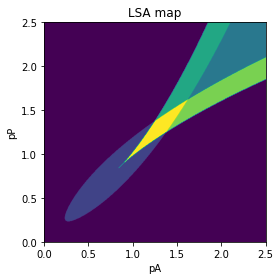

In [5]:
res = np.loadtxt('temp3/Res.txt')

def paramspace_fig(res):
    fig, ax = plt.subplots()
    
    ax.imshow(res.T, origin='lower', extent=(kAP_range[0], kAP_range[1], kPA_range[0], kPA_range[1]), aspect='auto')
    ax.set_xlabel('pA')
    ax.set_ylabel('pP')
    ax.set_title('LSA map')
      
    fig.set_size_inches(4, 4)
    fig.tight_layout()
    
paramspace_fig(res)

## Summary

This notebook demonstrates a quick way to perform linear stability analysis sweeps in 2D. As it relies purely on numerical methods, we can use this method with arbitrarily complex models, and do not need to solve any equations analytically.